<a href="https://colab.research.google.com/github/wallik2/ML_algorithm_FromScratch/blob/main/%5BScratch%5D_3_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree from scratch 🌲

![treememe](http://leapdesign.com/wp-content/uploads/2010/04/harold_decisiontree-560x795.jpg)

<fieldset>

Ref:  [Decision Trees from Scratch Using ID3 Python](https://medium.com/@lope.ai/decision-trees-from-scratch-using-id3-python-coding-it-up-6b79e3458de4)



---



# Setup libraries

In [1]:
import numpy as np
import pandas as pd

"""to avoid overflow (minimum at 16 decimal)"""
eps = np.finfo(float).eps

from numpy import log2 as log

print("Setup completed")

Setup completed




---



# Define the dataset

In [2]:
data = {'x1':["yes","yes","no","yes","yes","no","no","no","yes","yes","yes","no","no","yes","yes"],
        'x2':["male","female","female","male","male","male","male","female","male","male","female",
              "male","female","female","male"],
        'x3':["yes","no","yes","no","no","no","yes","yes","no","yes","yes","yes","no","no","no"],
        'x4':['never','rarely','chainsmoker','chainsmoker','rarely','never','rarely','chainsmoker','rarely',
              'chainsmoker','rarely','rarely','never','never','rarely'],  
        'y':['no','yes','no','yes','yes','yes','yes','no','yes','no','no','no','yes','yes','yes']}



---



# Create pandas dataframe

In [3]:
df = pd.DataFrame(data) ;df

,x1,x2,x3,x4,y
0,yes,male,yes,never,no
1,yes,female,no,rarely,yes
2,no,female,yes,chainsmoker,no
3,yes,male,no,chainsmoker,yes
4,yes,male,no,rarely,yes
5,no,male,no,never,yes
6,no,male,yes,rarely,yes
7,no,female,yes,chainsmoker,no
8,yes,male,no,rarely,yes
9,yes,male,yes,chainsmoker,no




---



# Decision tree algorithm<br>
1. compute the entropy for data-set<br>
2. for every attribute/feature:<br>
* 2.1.calculate entropy for all categorical values
* 2.2.calculate gain for the current attribute
3. pick the highest gain attribute.<br>
4. Repeat until we get the tree we desired<br>

<u>Note</u> : There are a lot of impurity measurement like gini, but in this case, we prefer using Entropy ⏩



---



# compute the entropy for data-set

<details>
  <summary><b> # Description 1</b></summary>

<fieldset>
Verbal description 1.1 : 

At very first step, we need to find the entropy of whole dataset, if the class entropy of the first round is 1, then it means the each category of the label share the equal proportion, but if it's zero, then all instances has the same label, which mean you can immediately stop, and don't use any attribute to help seperating the label anymore 



</fieldset>

<fieldset>
Verbal description 1.2 : 


```
df.y.value_counts()
```
``` 
yes    9
no     6
Name: y, dtype: int64
```

Since this dataset has 9 yes / 6 no, so the impurity is very high, (which almost is half and half)

That's why the entropy is very close to 1 





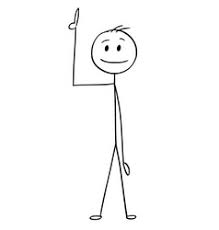

In [4]:
#start from label 'y'


entropy_node = 0  #Initialize Entropy
values = df.y.unique()  #Unique objects - 'Yes', 'No'
for value in values:
    fraction = df.y.value_counts()[value]/len(df.y)  
    entropy_node += -fraction*np.log2(fraction)
entropy_node 

0.9709505944546686

We find the entropy of class, by summing the entropy by using from the probability of each categories in the label



---



# calculate entropy for all categorical values

<details>
  <summary><b>Description 2</b></summary>

  <fieldset>

Verbal description 2.1 : 

Since without any help of attributes, the impurity is high (recall the entropy is approximately 0.97 )

So, we need helping hands from other attributes, which filtering the dataset given by the category in EACH attribute, then looking for the weighted average of the attribute entropy, and see is the entropy is lower than the class entropy or not. If the weighted average entropy of that attribute is equal to the class entropy, we consider it useless and doesn't help much to help seperating the impurity of the dataset

since this is the first round, the attribute that has the lowest weighted avg of entropy, will be chosen as a root node, or formally we can use Information gain to determine how much the attribute can help seperating the impurity of data compared to the class node

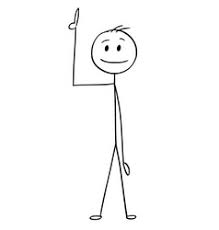

In [5]:
"""This function ent can filtering the df by the category of each attributes, and return the entropy of each attribute"""

def ent(df,attribute):
  #This gives all category of the label
    target_variables = df.y.unique()  

    #This gives different category in that attribute (eg. attribute sex: male , female)
    variables = df[attribute].unique()   


    entropy_attribute = 0

    # We dig to each attribute
    for variable in variables:
        entropy_each_feature = 0
        # Now dig to each category of the fixed attribute
        for target_variable in target_variables:
            # Find the proportion of each category of to the whole number of this attribute
            num = len(df[attribute][df[attribute]==variable][df.y ==target_variable])
            den = len(df[attribute][df[attribute]==variable]) 

            # we find the proportion of each category given the category of the label / we plus eps to avoid the case den = 0
            fraction = num/(den+eps)  

            # Entropy of each category in this attribute
            entropy_each_feature += -fraction*log(fraction+eps) 

        # Weighted average entropy of each category in this attribute    
        fraction2 = den/len(df)
        entropy_attribute += -fraction2*entropy_each_feature   #Sums up all the entropy ETaste

    return(abs(entropy_attribute))

In [6]:
"""Now we obtained the weighted avg entropy of each attribute"""

a_entropy ={}
for k in df.keys()[:-1]:
  a_entropy[k] = ent(df,k)
  # print(k,ent(df,k))
a_entropy

{'x1': 0.950977500432693,
 'x2': 0.950977500432693,
 'x3': 0.27611396333841903,
 'x4': 0.8354712650426314}

In [7]:
a_entropy

{'x1': 0.950977500432693,
 'x2': 0.950977500432693,
 'x3': 0.27611396333841903,
 'x4': 0.8354712650426314}



---



# calculate gain for the current attribute

<details>
  <summary><b> # Description 3</b></summary>

<fieldset>
Verbal description 3.1 : 

To look how much attribute helps compared to the old one (Just the class), we use Information Gain as the metrics



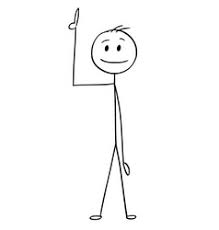

In [8]:
def ig(e_dataset,e_attr):
    return e_dataset - e_attr

In [9]:
IG = {}
for k in a_entropy:
  IG[k] = ig(entropy_node,a_entropy[k])
  # print(k, a_entropy[k])

IG

{'x1': 0.019973094021975557,
 'x2': 0.019973094021975557,
 'x3': 0.6948366311162495,
 'x4': 0.13547932941203722}



---



# complete code.

In [10]:
def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
  
def find_entropy_attribute(df,attribute):
  Class = df.keys()[-1]   #To make the code generic, changing target variable class name
  target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#       Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
        #print(np.max(IG))
    return (df.keys()[:-1][np.argmax(IG)],np.max(IG))
  
  
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)

In [11]:
#root_label = np.unique(df[df.keys()[-1]])
#root_label_count = len(root_label)

def buildTree(df,tree=None): 
    """start with the label"""
    Class = df.keys()[-1]   

    """find the root node (best attribute with highest IG)"""
    node = find_winner(df)[0]
    print("winner ", node)
    
    """categories of the winner node"""
    attValue = np.unique(df[node])
    
    """build tree and this is for only first round"""   
    if tree is None:                    
        tree={}
        
        tree[node] = {}

    """recursely append the node until the subset is pure"""
    for value in attValue:
        
        """each catgry. for the fixed attrb"""
        subtable = get_subtable(df,node,value)

        """yes/no for each category with counts"""
        clValue,counts = np.unique(subtable[df.columns[-1]],return_counts=True)   


        " only 1 label in that subtable deserves to be the last node "
        if len(counts) == 1:#Checking purity of subset
            tree[node][value] = clValue[0]         
            
        elif float("%.4f" % (find_winner(df)[1])) == 0:
            tree[node][value] = clValue[np.random.randint(0, len(counts))]      
            
          
        else:        
            #print(subtable)
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

In [12]:
buildTree(df)

winner  x3
winner  x4
winner  x1
winner  x1


{'x3': {'no': 'yes',
  'yes': {'x4': {'chainsmoker': 'no',
    'never': 'no',
    'rarely': {'x1': {'no': {'x1': {'no': 'no'}}, 'yes': 'no'}}}}}}

If the winner are duplicated attribute, it means you possibly have more than 1 model 

Since all the instance that x3 == yes, y will always equal no

So, here's a decision tree if-else algorithm



---



# Predict 3 unseen data

In [14]:
y = df.pop("y")

X = df

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_test

,x1,x2,x3,x4
9,yes,male,yes,chainsmoker
11,no,male,yes,rarely
0,yes,male,yes,never


In [17]:
for i in range(len(X_test)):

  if X_test.iloc[i,2] == "yes":
    X_test["pred_y"] = "no"
  else: 
    X_test["pred_y"] = "yes"

In [18]:
X_test

,x1,x2,x3,x4,pred_y
9,yes,male,yes,chainsmoker,no
11,no,male,yes,rarely,no
0,yes,male,yes,never,no




---

